<a href="https://colab.research.google.com/github/pierrickBERTHE/Projet9_OCR_DataScientist/blob/main/Berthe_Pierrick_1_notebook_052024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style='color:SteelBlue'>P9 - Réalisez un traitement dans un environnement Big Data sur le Cloud</span>

![Logo Fruits]()

# <span style='background:red; color:black'>MAJ à faire</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

**Etape 1 : Importation des données**

Conclusion

# <span style='background:blue'>Introduction</span>

L'entreprise "Fruits!" est une jeune entreprise qui a la volonté de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruit en développant des robots cueilleurs intelligents.

Pour cela, l'entreprise souhaite se faire connaitre en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit. Le developpement de cette application nécessite un traitement Big Data pour la reconnaissance d'image.
___
**Missions**

1/ Expliquer pas-à-pas le script PySpark implémenté avec :
- Un traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des « weights » du modèle)

- Une étape d’une réduction de dimension de type ACP en PySpark

2/ Faire une démonstration de la mise en place d’une instance EMR opérationnelle.

3/ Démontrer le respect des contraintes RGPD (serveurs situés sur le territoire européen).

4/ Donner mon retour critique sur cette solution (utile avant de la généraliser).
___

**Source des datasets**<br>
Ce jeux de données comporte des images de fruits pour train et test un modèle de reconnaissance d'image.

Nombre d'images : 90_483<br>
Nombre de classes : 131<br>
Taille des images : 100x100 pixels<br>

3 dossiers :
- Training (67_692 images)
- Test (22_688 images)
- test-multiple_fruits


Source : [Fruits-360 dataset](https://www.kaggle.com/datasets/moltean/fruits) sur Kaggle.com<br>

# <span style='background:grey'>Importations des librairies</span>

Liste des imports généraux :

In [96]:
!pip install Pandas pillow tensorflow pyspark pyarrow

In [97]:
!pip install pyngrok

In [98]:
# Librairies generales
import os
import os.path
import sys
import time
from datetime import datetime

# Librairies data science
import pandas as pd
from PIL import Image
import numpy as np
import io

# Librairies TensorFlow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Librairies Spark
from pyspark import SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

# Pour Google Colab
from google.colab import drive
drive.mount('/content/drive')
print("\nConnecté à Google Drive\n")

# pyngrok pour SparkUI
import getpass
import pyngrok
from pyngrok import ngrok, conf

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")

print("Version des librairies utilisées :")
print("Pyngrok       : " + pyngrok.__version__)
print("NumPy         : " + np.__version__)
print("Pandas        : " + pd.__version__)
print("Pillow (Image): " + Image.__version__)
print("Tensorflow    : " + tf.__version__)
print("PySpark       : " + SparkSession.builder.getOrCreate().version)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Connecté à Google Drive

Interpréteur python :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Version des librairies utilisées :
Pyngrok       : 7.1.6
NumPy         : 1.25.2
Pandas        : 2.0.3
Pillow (Image): 9.4.0
Tensorflow    : 2.15.0
PySpark       : 3.5.1

Code lance le : 2024-05-24T13:48:00.171886


J'ai également copié le fichier "hadoop.dll" dans le dossier "*C:\Windows\System32*" pour éviter une erreur lors de l'importation des données. Ce fichier est issue du git de winutils : [git winutils/hadoop-3.4.0-win10-x64/bin](https://github.com/kontext-tech/winutils/tree/master/hadoop-3.4.0-win10-x64/bin)

Il faut ensuite définir la variable d'environnement "HADOOP_HOME" qui pointe vers le dossier contenant le fichier "hadoop.dll".

In [99]:
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['HADOOP_HOME'] = "C:\\Program Files\\Hadoop\\"

# <span style='background:grey'>Paramètres d'affichage</span>

pyngrok

In [100]:
get_ipython().system_raw('./ngrok http 4040 &')

# <span style='background:grey'>Fonctions</span>


In [101]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée d'éxécution du notebook.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """
    # Calculer la durée totale et convertir en minutes et secondes
    minutes, seconds = divmod(time.time() - start_time, 60)

    # Afficher la durée totale
    print(f"Durée execution notebook : {int(minutes)} min {int(seconds)} sec")

# <span style='background:blue'>Etape 1 : Déploiement de la solution en local</span>

## <span style='background:green'>1/Importation des données</span>

Echantillon de 3 type de pommes (1_400 images)

In [102]:
# Afficher le répertoire de travail actuel
print("Current directory avant chdir :", os.getcwd())

# Vérifier si le code est exécuté dans Google Colab
is_google_colab = 'COLAB_GPU' in os.environ
print("Execution in Google Colab : ", is_google_colab, "\n")

# Definir le chemin d'import des fichiers sur Google Colab ou PC local
if is_google_colab:

    # Changer le répertoire courant
    PATH = "/content/drive/MyDrive/Colab Notebooks/P9"
    os.chdir(PATH)
    print("Current directory apres chdir :", os.getcwd())

else:

    # Conserver repertoire PC local
    PATH = "."
    print("Current directory ne doit pas avoir changé :", os.getcwd(), '\n')

PATH_Data = PATH + '/data/source/dataset_sample'
PATH_Result_features = PATH + '/results/features_parquet'
PATH_Result_pca_parquet = PATH + '/results/pca_parquet'
PATH_Result_pca_csv = PATH + '/results/pca_csv'

# List of paths
paths = [PATH_Data, PATH_Result_features, PATH_Result_pca_parquet, PATH_Result_pca_csv]

# Create the directories if they don't exist
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

print(
    'PATH:        ' + PATH +\
    '\nPATH_Data:   ' + PATH_Data +\
    '\nPATH_Result_features: '+ PATH_Result_features +\
    '\nPATH_Result_pca_parquet: '+ PATH_Result_pca_parquet +\
    '\nPATH_Result_pca_csv: '+ PATH_Result_pca_csv
)

Current directory avant chdir : /content/drive/My Drive/Colab Notebooks/P9
Execution in Google Colab :  True 

Current directory apres chdir : /content/drive/MyDrive/Colab Notebooks/P9
PATH:        /content/drive/MyDrive/Colab Notebooks/P9
PATH_Data:   /content/drive/MyDrive/Colab Notebooks/P9/data/source/dataset_sample
PATH_Result_features: /content/drive/MyDrive/Colab Notebooks/P9/results/features_parquet
PATH_Result_pca_parquet: /content/drive/MyDrive/Colab Notebooks/P9/results/pca_parquet
PATH_Result_pca_csv: /content/drive/MyDrive/Colab Notebooks/P9/results/pca_csv


## <span style='background:green'>2/Création de la SparkSession</span>


In [103]:
# Arrête la session Spark existante, si elle existe
SparkSession.builder.getOrCreate().stop()

# Créer une session Spark
spark = (SparkSession
                    .builder
                    .appName('P9')
                    .master('local')
                    .config("spark.sql.parquet.writeLegacyFormat", 'true')
                    .getOrCreate()
)

In [104]:
sc = spark.sparkContext

In [105]:
spark

## <span style='background:green'>3/Traitement des données</span>

### <span style='background:black'>a/Chargement des données</span>


In [106]:
images = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(PATH_Data)

In [107]:
# Ajout de la col label à partir du nom du dernier dossier contenant l'image
images = images.withColumn('label', element_at(split(images['path'], '/'), -2))

# Afficher le schema et les 5 premières lignes
print(images.printSchema())
# print(images.select('path', 'label').show(5, False))
print(images.show(5))

# Imprimer le nombre de lignes dans le DataFrame
print("Nombre de lignes dans le DataFrame : ", images.count())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------+-------------------+------+--------------------+--------------+
|                path|   modificationTime|length|             content|         label|
+--------------------+-------------------+------+--------------------+--------------+
|file:/content/dri...|2021-09-12 17:25:44|  5879|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5865|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5861|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5856|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5856|[FF D8 FF E0 00 1...|Apple Golden 1|
+--------------------+-------------------+------+--------------------+--------------+
only showing top

### <span style='background:black'>b/Préparation du modèle</span>


In [108]:
model = MobileNetV2(
    weights='imagenet',
    include_top=True,
    input_shape=(224, 224, 3)
)

In [109]:
new_model = Model(
    inputs=model.input,
    outputs=model.layers[-2].output
)

A décommenter à la fin :

In [110]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [111]:
broadcast_weights = sc.broadcast(new_model.get_weights())

In [112]:
def model_fn():
    """
    Cette fonction crée un modèle MobileNetV2 avec des poids pré-entraînés à partir d'ImageNet, retire la couche supérieure du modèle, rend toutes les couches non entraînables (c'est-à-dire, leurs poids ne seront pas mis à jour pendant l'entraînement), puis définit les poids du nouveau modèle à partir d'une valeur diffusée.

    :return: Le nouveau modèle avec les poids pré-entraînés diffusés.
    """
    # Créer modèle MobileNetV2 avec des poids pré-entraînés à partir d'ImageNet
    model = MobileNetV2(
        weights='imagenet',
        include_top=True,
        input_shape=(224, 224, 3)
    )

    # Rendre les couches non entraînables
    for layer in model.layers:
        layer.trainable = False

    # création nouveau modèle sans la dernière couche
    new_model = Model(
        inputs=model.input,
        outputs=model.layers[-2].output
    )

    # transmettre les poids du modèle
    new_model.set_weights(broadcast_weights.value)

    return new_model

### <span style='background:black'>c/Préparation du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF</span>


In [113]:
def preprocess(content):
    """
    Cette fonction charge une image à partir des données brutes, redimensionne
    l'image à une taille de 224x224 pixels, la convertit en un tableau numpy,
    puis applique la fonction de prétraitement de MobileNetV2.

    :param content: Les données brutes de l'image à prétraiter.

    :return: Le tableau numpy de l'image prétraitée.
    """
    # Chargement de l'image et redimensionnement à 224x224
    img = Image.open(io.BytesIO(content)).resize([224, 224])

    # Conversion en tableau numpy
    arr = img_to_array(img)

    # Application de la fonction preprocess_input de MobileNetV2
    return preprocess_input(arr)

In [114]:
def featurize_series(model, content_series):
    """
    Effectue une caractérisation (featurization) d'une pd.Series d'images
    brutes en utilisant le modèle en entrée.

    :param model: Un modèle de deep learning pré-entraîné pour la
    caractérisation des images.
    :param content_series: Une pd.Series contenant des images brutes à
    caractériser.

    :return: Une pd.Series où chaque élément est un vecteur unidimensionnel
    de caractéristiques d'image.
    """
    # Application prétraitement à chaque image brute et empilement dans array
    input = np.stack(content_series.map(preprocess))

    # Utilisation du modèle pour prédire les caractéristiques de l'image
    preds = model.predict(input)

    # Applatissement des caractéristiques en 1 vecteur 1D (besoin pour Spark)
    output = [p.flatten() for p in preds]

    # Conversion en pd.Series
    return pd.Series(output)

In [115]:
# Decorateur pour définir une UDF pandas de type Scalar Iterator
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)

def featurize_udf(content_series_iter):
    '''
    Cette méthode est une UDF pandas de type Scalar Iterator qui enveloppe
    notre fonction de featurisation. Le décorateur spécifie qu'elle renvoie
    une colonne de DataFrame Spark de type ArrayType(FloatType).

    :param content_series_iter: Cet argument est un itérateur sur des lots de
    données, où chaque lot est une série pandas de données d'image.
    '''
    # Charger le modèle une fois  (réutiliser pour plusieurs lots de données)
    model = model_fn()

    # POUR chaque lot de données
    for content_series in content_series_iter:
        print("Lot de données de taille : ", content_series.shape)

        # Application de la fonction de featurisation (du modele sur le lot)
        yield featurize_series(model, content_series)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### <span style='background:black'>d/Exécution des actions d'extraction de features</span>

In [116]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [117]:
# 20 partitions + select col path & label + featurize & rename col content
features_df = images.repartition(20).select(
    col("path"),
    col("label"),
    featurize_udf("content").alias("features")
)

In [118]:
features_df.columns

['path', 'label', 'features']

In [119]:
print(PATH_Result_features)

/content/drive/MyDrive/Colab Notebooks/P9/results/features_parquet


In [120]:
features_df.write.mode("overwrite").parquet(PATH_Result_features)

Chargement des données enregistrées et validation du résultat

In [121]:
df = pd.read_parquet(PATH_Result_features, engine='pyarrow')

In [122]:
df

,path,label,features
0,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.8536301, 0.0, 0.0, 0.013514129, 0..."
1,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.027579853, 0.0, 0.0, 0.0, 0.022468586,..."
2,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.07077724, 1.4807837, 0.0, 0.60484815, ..."
3,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85552526, 0.0..."
4,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.07511413, 1.1581838, 0.0, 0.15176162, ..."
...,...,...,...
1395,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.0007490431, 0.0, 0.0, 0.0, 0.0, 1.1925205, ..."
1396,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.12012962, 0.034390878, 0.0, 0.0, 0.0, 0.115..."
1397,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.08103858, 0.016659036, 0.0, 0.0, 0.0, 0.061..."
1398,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.10410906, 0.0, 0.0, 0.0, 0.0, 0.0, 1.191049..."


In [123]:
df.loc[0,'features']

array([0.        , 0.        , 0.8536301 , ..., 0.        , 0.33552766,
       0.        ], dtype=float32)

In [124]:
df.loc[0,'features'].shape

(1280,)

PCA

In [125]:
df['features']

0       [0.0, 0.0, 0.8536301, 0.0, 0.0, 0.013514129, 0...
1       [0.0, 0.027579853, 0.0, 0.0, 0.0, 0.022468586,...
2       [0.0, 0.07077724, 1.4807837, 0.0, 0.60484815, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85552526, 0.0...
4       [0.0, 0.07511413, 1.1581838, 0.0, 0.15176162, ...
                              ...                        
1395    [0.0007490431, 0.0, 0.0, 0.0, 0.0, 1.1925205, ...
1396    [0.12012962, 0.034390878, 0.0, 0.0, 0.0, 0.115...
1397    [0.08103858, 0.016659036, 0.0, 0.0, 0.0, 0.061...
1398    [0.10410906, 0.0, 0.0, 0.0, 0.0, 0.0, 1.191049...
1399    [0.08059602, 0.0, 0.0, 0.0, 0.0, 0.004480946, ...
Name: features, Length: 1400, dtype: object

In [126]:
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

In [127]:
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())# cree une fonction udf pour transformer un array en vector UDT

features_df = features_df.withColumn("features_array", array_to_vector_udf(col("features")))

features_df.show()

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|      features_array|
+--------------------+--------------+--------------------+--------------------+
|file:/content/dri...|Apple Golden 1|[0.0, 0.0, 0.8536...|[0.0,0.0,0.853630...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.027579853...|[0.0,0.0275798533...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.07077724,...|[0.0,0.0707772374...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.07511413,...|[0.0,0.0751141309...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.23927934,...|[0.0,0.2392793446...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.2569102, ...|[0.0,0.2569102048...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.46014333,...|[0.0,0.4601433277...|
|file:/content/dri...|Apple Braeburn|[0.39683127, 0.16...|[0.39683127403259...|
|file:/content/dri...|Apple Golden 1|[0.

In [128]:
features_df.select('features_array').show()

+--------------------+
|      features_array|
+--------------------+
|[0.0,0.0060093258...|
|[0.0,0.0232469793...|
|[0.0,0.0462028943...|
|[0.0,0.0580478794...|
|[0.0,0.1752524822...|
|[0.23649534583091...|
|[0.0,0.0,0.0,0.0,...|
|[0.35796955227851...|
|[0.39683127403259...|
|[0.0,0.0,0.008053...|
|[0.0,0.3620758056...|
|[0.0,0.1016691550...|
|[0.24303105473518...|
|[0.01065897475928...|
|[0.00270657637156...|
|[0.0,0.0,0.113010...|
|[0.0,0.0050689834...|
|[0.00827333889901...|
|[0.00432053394615...|
|[0.29457539319992...|
+--------------------+
only showing top 20 rows



In [129]:
nbr_composante = 600

# Apply PCA with a large number of components
pca = PCA(k=nbr_composante, inputCol="features_array", outputCol="pca_features")
model_fitted = pca.fit(features_df)
pca_result = model_fitted.transform(features_df)

# Calculate the total variance
total_variance = sum(model_fitted.explainedVariance)
print("Total Variance: ", total_variance)

# Calculate the cumulative sum of explained variances
cumulative_variance = np.cumsum(model_fitted.explainedVariance)

# Create a table to show the explained variance for each set of 100 components
explained_variance_table = []
for i in range(0, nbr_composante, 1):
    explained_variance = cumulative_variance[i] / total_variance
    explained_variance_table.append((i, explained_variance))

    # Print que les multiple de 50
    if i % 50 == 0:
        print(f"Explained variance with {i} components: {explained_variance}")

# Save the PCA results
pca_result.write.mode('overwrite').parquet(PATH_Result_pca_parquet)

# Show the PCA result
pca_result.show(truncate=False)
print("Number of rows: ", pca_result.count())
print("Number of columns: ", len(pca_result.columns))

Total Variance:  0.9987555684353873
Explained variance with 0 components: 0.4158241701650825
Explained variance with 50 components: 0.9331011061529535
Explained variance with 100 components: 0.9667641632434317
Explained variance with 150 components: 0.9792601532729797
Explained variance with 200 components: 0.9859938066548565
Explained variance with 250 components: 0.9902422782798427
Explained variance with 300 components: 0.9931604967803096
Explained variance with 350 components: 0.9952641715440042
Explained variance with 400 components: 0.9968135353172953
Explained variance with 450 components: 0.9979774627177628
Explained variance with 500 components: 0.9988523688852144
Explained variance with 550 components: 0.9995121824581434
+------------------------------------------------------------------------------------------------------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------

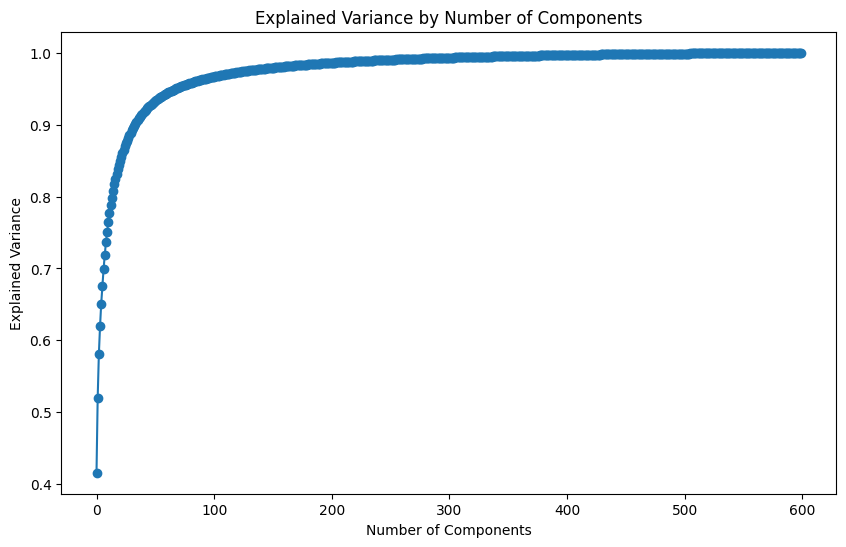

In [130]:
import matplotlib.pyplot as plt

# Unpack the number of components and explained variances into two lists
components, variances = zip(*explained_variance_table)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(components, variances, marker='o')

# Add labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Components')

# Show the plot
plt.show()

In [131]:
pca_result.columns

['path', 'label', 'features', 'features_array', 'pca_features']

chargement des resultats PCA pour voir

In [132]:
df_result_pca = pd.read_parquet(PATH_Result_pca_parquet, engine='pyarrow')

In [133]:
df_result_pca

,path,label,features,features_array,pca_features
0,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.8536301, 0.0, 0.0, 0.013514129, 0...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.027579853, 0.0, 0.0, 0.0, 0.022468586,...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.07077724, 1.4807837, 0.0, 0.60484815, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85552526, 0.0...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.07511413, 1.1581838, 0.0, 0.15176162, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
...,...,...,...,...,...
1395,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.0007490431, 0.0, 0.0, 0.0, 0.0, 1.1925205, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1396,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.12012962, 0.034390878, 0.0, 0.0, 0.0, 0.115...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1397,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.08103858, 0.016659036, 0.0, 0.0, 0.0, 0.061...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1398,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.10410906, 0.0, 0.0, 0.0, 0.0, 0.0, 1.191049...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."


In [134]:
df_result_pca.loc[0, 'pca_features']['values']

array([ 5.94842890e+00,  1.93730939e+00,  1.95208140e+00, -4.18399428e+00,
        2.99981380e-01,  4.03388666e+00, -2.40883569e+00,  1.91680731e+00,
       -3.03545557e-01, -1.25226712e+00, -1.54774769e+00,  2.72994711e-01,
        4.45999908e+00,  5.63274152e-01, -6.25238933e+00,  2.11286170e+00,
        1.33074264e+00, -4.19921691e+00,  2.54999802e+00,  1.88672703e+00,
       -2.16434051e+00, -1.17371349e+00, -2.37491330e+00, -1.04921603e+00,
        2.21702054e+00,  3.36510477e-01, -2.25433813e-01,  1.18994516e+00,
       -4.65251479e+00,  2.03955229e+00,  1.05333279e+00, -1.49565236e+00,
       -1.56418592e+00, -1.29141852e+00,  2.74836080e+00,  1.35902627e+00,
       -1.46856712e+00,  2.53021692e-01,  1.26749778e+00, -1.64438751e+00,
       -1.08649661e+00,  4.45900947e-01,  1.01932050e+00, -4.33148452e+00,
        1.87471508e+00,  7.92730441e-01, -2.05093746e+00,  1.83163572e+00,
       -5.92640726e-01, -1.39597013e+00, -6.11413835e-01, -5.90610589e-04,
        2.45515645e+00, -

In [135]:
# Create a new column 'values' that contains the 'values' from the 'pca_features' column
df_result_pca['values'] = df_result_pca['pca_features'].apply(lambda x: x['values'])

# Convert the 'values' column to a DataFrame
values_df = df_result_pca['values'].apply(pd.Series)

# Join the paths
csv_path = os.path.join(PATH_Result_pca_csv, 'values_pca.csv')

# Export the DataFrame to a CSV file
values_df.to_csv(csv_path, index=False)

In [136]:
values_pca_df = pd.read_csv(csv_path)
values_pca_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,5.948429,1.937309,1.952081,-4.183994,0.299981,4.033887,-2.408836,1.916807,-0.303546,-1.252267,...,-0.215989,-0.128972,0.115314,0.170495,0.014584,0.296696,0.064742,0.107678,-0.066876,0.015830
1,6.889809,-2.938019,2.774483,-4.523400,-3.493311,1.903702,-1.926287,1.203354,-1.895595,2.843713,...,-0.261677,-0.103547,0.118430,0.138473,-0.028621,0.386584,-0.005697,0.122754,-0.007066,-0.010394
2,5.838759,-3.107685,3.698646,0.781711,-2.671348,0.915284,-4.814949,7.917868,-1.628783,2.176560,...,-0.222094,-0.138797,0.095794,0.116335,0.037951,0.327183,-0.088494,0.140816,0.099443,-0.029745
3,4.372832,2.648204,-0.312655,-4.697692,1.977012,2.872878,-1.773569,1.250132,-0.173296,-1.097293,...,-0.248120,-0.186935,0.054312,0.067535,0.007694,0.390491,-0.062608,0.127580,0.028567,0.107765
4,5.515549,-3.018862,3.212358,-0.487114,-2.756908,1.653326,-4.000674,7.620791,-0.980776,1.569827,...,-0.254655,-0.236305,0.120466,0.060611,-0.018757,0.322143,-0.017612,0.003245,-0.010141,0.126969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,-11.585309,1.094714,-4.552549,-3.807686,-6.870581,4.503956,-3.396808,3.226688,-0.056828,-0.965089,...,-0.213265,-0.181111,0.105717,0.170985,-0.033977,0.321151,-0.009939,0.122030,-0.049573,0.049639
1396,-10.182073,-3.217230,-4.730994,-4.635062,-5.114321,3.907801,-4.411277,0.804976,0.115435,-1.152460,...,-0.264234,-0.186431,0.067893,0.064008,-0.016387,0.341005,0.018724,0.075961,0.015518,0.159089
1397,-12.341293,-4.365907,-4.191993,-4.611495,-4.141735,2.971214,-4.216890,1.506206,-1.758828,-1.527339,...,-0.174072,-0.116946,0.049944,0.195685,-0.085467,0.311641,0.009083,0.080613,-0.058103,0.059098
1398,-10.818610,-3.599150,-4.356753,-4.427259,-4.224480,2.776603,-4.886380,2.310269,-0.612646,-1.345814,...,-0.295866,-0.219334,0.128831,0.125541,-0.030002,0.352455,-0.002257,0.159777,-0.009020,0.034139


Pour visualiser SparkUI sur pyngrok

In [139]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=4040
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://888955ff62c5:{port}\"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


 * ngrok tunnel "https://24f8-34-30-176-64.ngrok-free.app" -> "http://888955ff62c5:4040"


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier....<br>

# <span style='background:blue'>Conclusion</span>

Ici

In [138]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée execution notebook : 13 min 29 sec
